In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/dataset'

/content/drive/My Drive/dataset


In [3]:
# importing dependencies

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout


In [4]:
# constant 
IMAGE_SIZE = 224

# Training config
epochs = 100
batch_size = 32
normalization_factor = 255

In [5]:
# PATHS
glaucoma_positive_train_path = '/content/drive/My Drive/dataset/train/GP'
glaucoma_negative_train_path = '/content/drive/My Drive/dataset/train/GN'

glaucoma_positive_val_path = '/content/drive/My Drive/dataset/val/GP'
glaucoma_negative_val_path = '/content/drive/My Drive/dataset/val/GN'

glaucoma_positive_test_path = '/content/drive/My Drive/dataset/test/GP'
glaucoma_negative_test_path = '/content/drive/My Drive/dataset/test/GN'


In [6]:
glaucoma_positive_train_files = glob(glaucoma_positive_train_path + '/*')
glaucoma_negative_train_files = glob(glaucoma_negative_train_path + '/*')

glaucoma_positive_val_files = glob(glaucoma_positive_val_path + '/*')
glaucoma_negative_val_files = glob(glaucoma_negative_val_path + '/*')

glaucoma_positive_test_files = glob(glaucoma_positive_test_path + '/*')
glaucoma_negative_test_files = glob(glaucoma_negative_test_path + '/*')


In [7]:
# Preparing Train Labels
glaucoma_positive_train_labels = []
glaucoma_negative_train_labels = []

glaucoma_positive_train_images=[]
glaucoma_negative_train_images=[]

# Preparing Test Labels
glaucoma_positive_test_labels = []
glaucoma_negative_test_labels = []

glaucoma_positive_test_images=[]
glaucoma_negative_test_images=[]

# Preparing val Labels
glaucoma_positive_val_labels = []
glaucoma_negative_val_labels = []

glaucoma_positive_val_images=[]
glaucoma_negative_val_images=[]



In [8]:
for i in range(len(glaucoma_positive_train_files)):
  image = cv2.imread(glaucoma_positive_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_train_images.append(image)
  glaucoma_positive_train_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_train_files)):
  image = cv2.imread(glaucoma_negative_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_train_images.append(image)
  glaucoma_negative_train_labels.append('Glaucoma Negative')

for i in range(len(glaucoma_positive_test_files)):
  image = cv2.imread(glaucoma_positive_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_test_images.append(image)
  glaucoma_positive_test_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_test_files)):
  image = cv2.imread(glaucoma_negative_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_test_images.append(image)
  glaucoma_negative_test_labels.append('Glaucoma Negative')

for i in range(len(glaucoma_positive_val_files)):
  image = cv2.imread(glaucoma_positive_val_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_val_images.append(image)
  glaucoma_positive_val_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_val_files)):
  image = cv2.imread(glaucoma_negative_val_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_val_images.append(image)
  glaucoma_negative_val_labels.append('Glaucoma Negative')



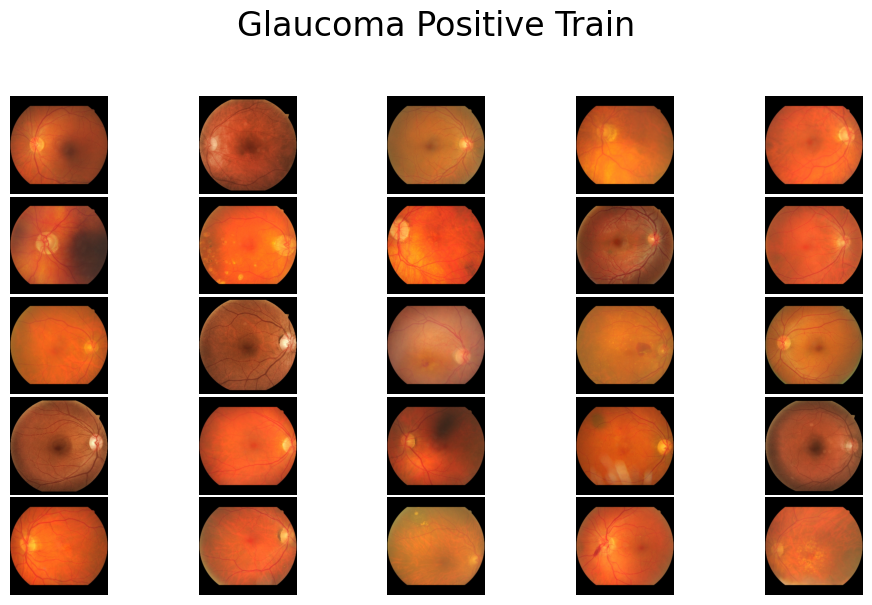

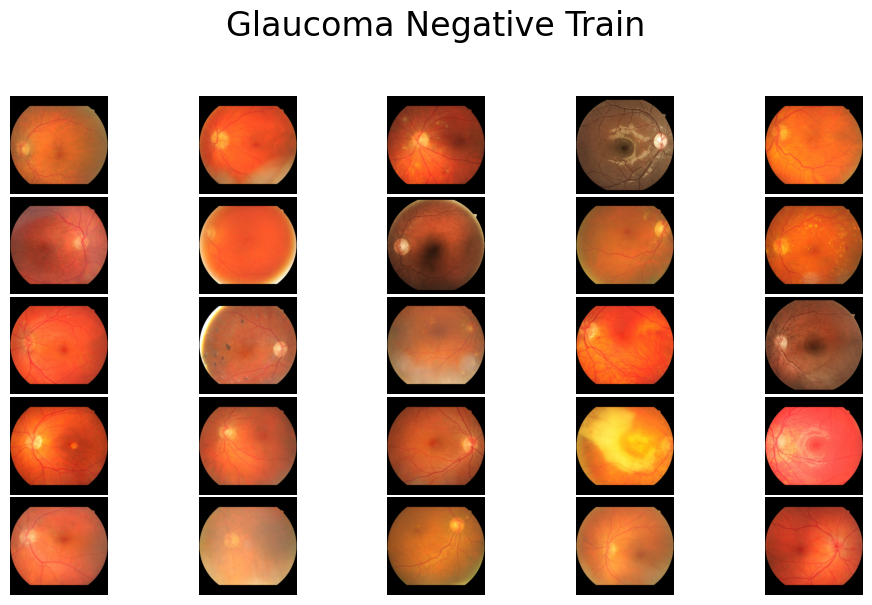

In [9]:
def plot_images(images, title):
    nrows, ncols = 5, 5
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

# plot Train Dataset
plot_images(glaucoma_positive_train_images, 'Glaucoma Positive Train')
plot_images(glaucoma_negative_train_images, 'Glaucoma Negative Train')




In [10]:
# normalize to interval of [0,1] for train dataset
glaucoma_positive_train_images = np.array(glaucoma_positive_train_images) / normalization_factor
glaucoma_negative_train_images = np.array(glaucoma_negative_train_images) / normalization_factor

# normalize to interval of [0,1] for test dataset
glaucoma_positive_test_images = np.array(glaucoma_positive_test_images) / normalization_factor
glaucoma_negative_test_images = np.array(glaucoma_negative_test_images) / normalization_factor


In [11]:
# normalize to interval of [0,1] for val dataset
glaucoma_positive_val_images = np.array(glaucoma_positive_val_images) / normalization_factor
glaucoma_negative_val_images = np.array(glaucoma_negative_val_images) / normalization_factor


In [12]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# images
X_train = np.concatenate((glaucoma_negative_train_images, glaucoma_positive_train_images), axis=0)
X_val = np.concatenate((glaucoma_negative_val_images, glaucoma_positive_val_images), axis=0)
X_test = np.concatenate((glaucoma_negative_test_images, glaucoma_positive_test_images), axis=0)

# labels
y_train = np.concatenate((glaucoma_negative_train_labels, glaucoma_positive_train_labels), axis=0)
y_val = np.concatenate((glaucoma_negative_val_labels, glaucoma_positive_val_labels), axis=0)
y_test = np.concatenate((glaucoma_negative_test_labels, glaucoma_positive_test_labels), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_val = LabelBinarizer().fit_transform(y_val)
y_val = to_categorical(y_val)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [13]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

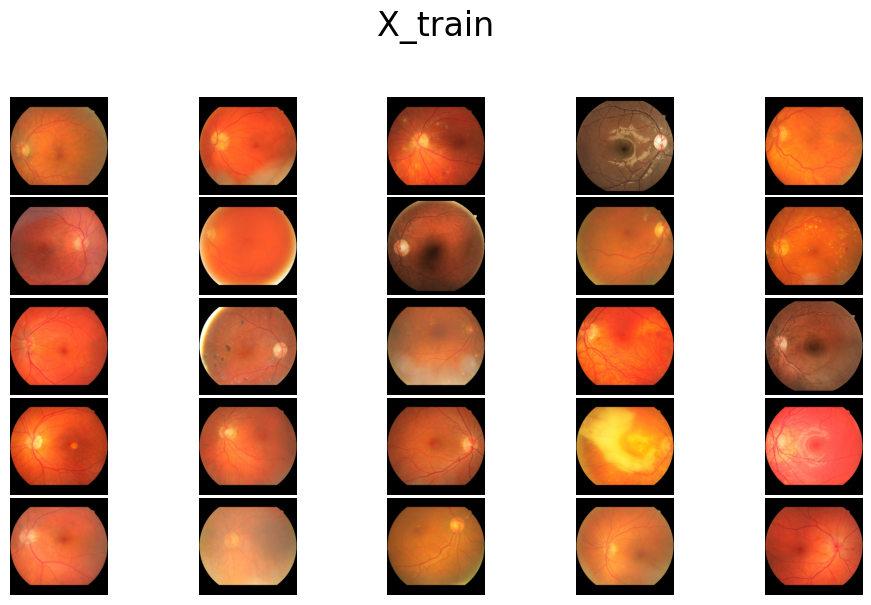

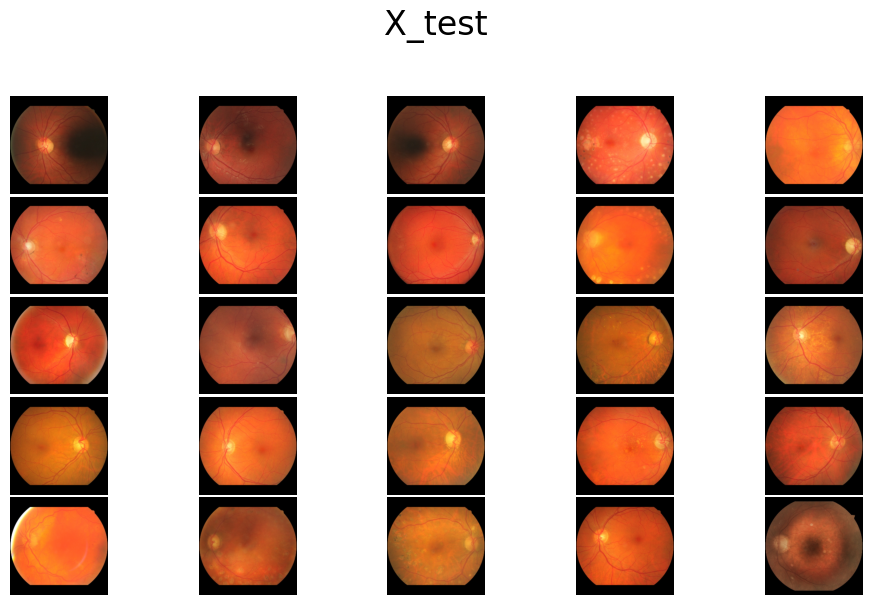

In [14]:
plot_images(X_train, 'X_train')
plot_images(X_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing glaucoma_Negative and glaucoma_Positive for X_train and X_test


In [ ]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, a):
        self.var = tf.Variable(a, name="var_a")

    def call(self, inputs, training=False):
        if training:
            return inputs * self.var
        else:
            return inputs

    def get_config(self):
        return {"a": self.var.numpy()}

    # There's actually no need to define `from_config` here, since returning
    # `cls(**config)` is the default behavior.
    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [15]:
inception = InceptionResNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.7)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False


model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

219055592/219055592 [==============================] - 9s 0us/step


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
# Clear previous TensorFlow graph and sessions
import tensorflow as tf
tf.keras.backend.clear_session()

In [18]:
train_data_gen = train_aug.flow(X_train, y_train, batch_size=batch_size)
print(train_data_gen)  # Print the generator object
train_data, train_labels = next(train_data_gen)
print(train_data.shape)  # (batch_size, height, width, channels)
print(train_labels.shape)


(32, 224, 224, 3)
(32, 2)


In [19]:
val_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_data_gen = val_aug.flow(X_val, y_val, batch_size=batch_size)
print(val_data_gen)  # Print the generator object
val_data, val_labels = next(val_data_gen)
print(val_data.shape)  # (batch_size, height, width, channels)
print(val_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [20]:
test_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_data_gen = test_aug.flow(X_test, y_test, batch_size=batch_size)
print(test_data_gen)  # Print the generator object
test_data, test_labels = next(test_data_gen)
print(test_data.shape)  # (batch_size, height, width, channels)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [21]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=100)

Epoch 1/100
27/27 [==============================] - 42s 731ms/step - loss: 4.6074 - accuracy: 0.5973 - val_loss: 1.0861 - val_accuracy: 0.6902
Epoch 2/100
27/27 [==============================] - 14s 510ms/step - loss: 2.1604 - accuracy: 0.6199 - val_loss: 1.3916 - val_accuracy: 0.5725
Epoch 3/100
27/27 [==============================] - 15s 528ms/step - loss: 2.6369 - accuracy: 0.6346 - val_loss: 1.3345 - val_accuracy: 0.7294
Epoch 4/100
27/27 [==============================] - 15s 541ms/step - loss: 2.3285 - accuracy: 0.6731 - val_loss: 1.2330 - val_accuracy: 0.6549
Epoch 5/100
27/27 [==============================] - 15s 531ms/step - loss: 2.4109 - accuracy: 0.6618 - val_loss: 1.2289 - val_accuracy: 0.6235
Epoch 6/100
27/27 [==============================] - 15s 532ms/step - loss: 2.4293 - accuracy: 0.6380 - val_loss: 1.2697 - val_accuracy: 0.7137
Epoch 7/100
27/27 [==============================] - 23s 835ms/step - loss: 3.3010 - accuracy: 0.6188 - val_loss: 1.2972 - val_accuracy:

In [24]:
model.save('inception_model_epoch.h5')

In [23]:
model.save('mymodel', save_format='tf')

In [ ]:
#model.save_weights('inception_model_epoch500.hdf5')

reloaded_model = tf.keras.experimental.load_from_saved_model('model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
print(reloaded_model.get_config())

#Get input shape from model.get_config()
reloaded_model.build((None, 224, 224, 3))
reloaded_model.summary()



In [26]:
model = load_model('inception_model_epoch.h5')


In [27]:
X_test.shape

(255, 224, 224, 3)

In [28]:
y_pred = model.predict(X_test, batch_size=batch_size)


8/8 [==============================] - 5s 177ms/step


In [29]:
y_pred

array([[3.25368223e-04, 9.99674678e-01],
       [1.00000000e+00, 7.00529912e-11],
       [9.88984466e-01, 1.10154990e-02],
       [1.00000000e+00, 1.21857718e-10],
       [9.97784078e-01, 2.21595634e-03],
       [9.99199450e-01, 8.00614129e-04],
       [1.00000000e+00, 1.24386483e-08],
       [9.75633025e-01, 2.43669022e-02],
       [9.99999762e-01, 2.13982290e-07],
       [1.00000000e+00, 1.28053063e-11],
       [8.41395497e-01, 1.58604518e-01],
       [1.00000000e+00, 1.66018078e-13],
       [9.99688268e-01, 3.11800861e-04],
       [1.80575088e-01, 8.19424927e-01],
       [1.00000000e+00, 3.96299482e-09],
       [5.26298862e-03, 9.94736969e-01],
       [8.32261801e-01, 1.67738214e-01],
       [3.36942480e-06, 9.99996662e-01],
       [1.66153997e-01, 8.33846033e-01],
       [9.99968886e-01, 3.11187650e-05],
       [2.13859171e-01, 7.86140800e-01],
       [9.99996424e-01, 3.58244642e-06],
       [1.00000000e+00, 3.51395829e-10],
       [5.63180493e-03, 9.94368136e-01],
       [9.696210

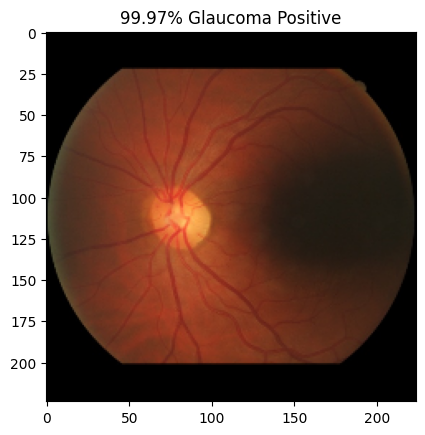

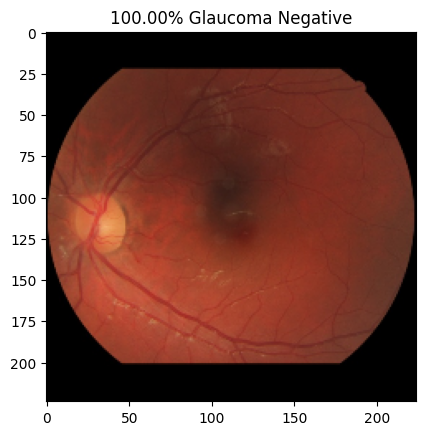

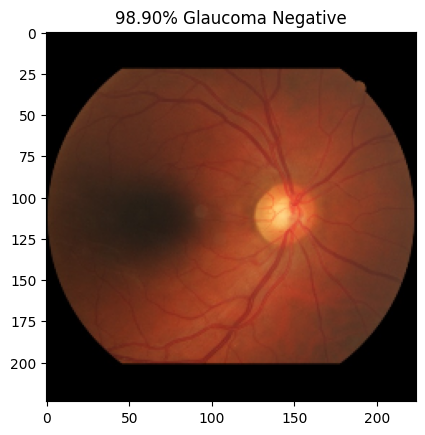

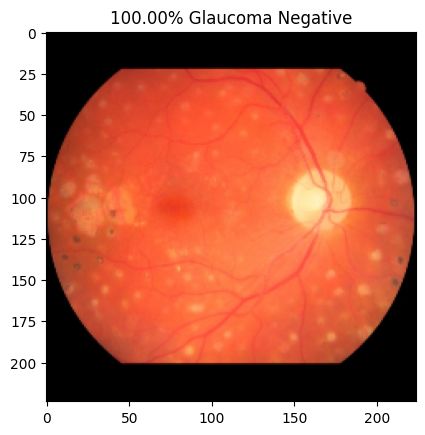

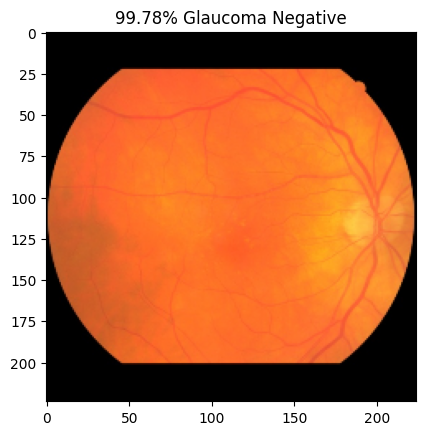

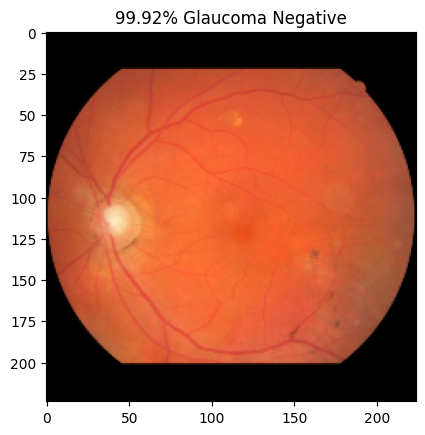

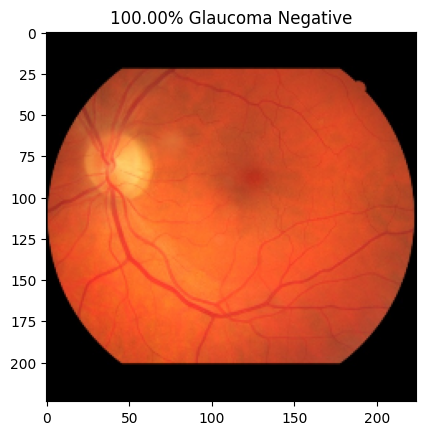

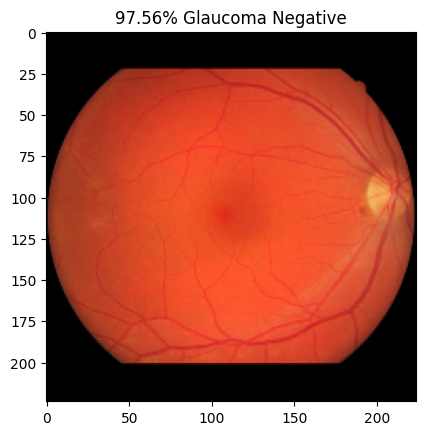

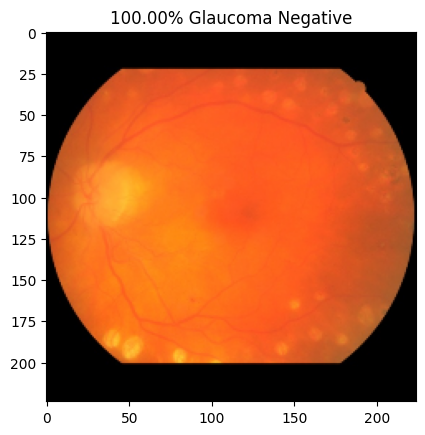

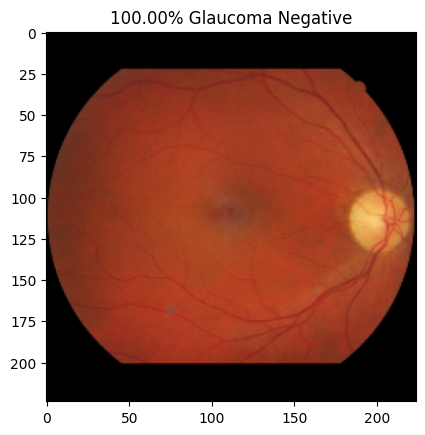

In [30]:
prediction = y_pred[:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Glaucoma Positive')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Glaucoma Negative')

 
  plt.imshow(X_test[index])
  plt.show()


In [31]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [32]:
y_test_bin 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
y_pred_bin

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bin,y_pred_bin)
print(cm)

[[120  29]
 [ 36  70]]


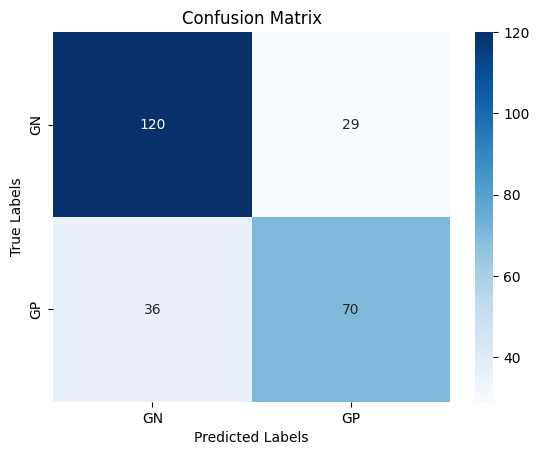

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)

# Set labels for plot
labels = ['GN','GP']

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Set plot labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       149
           1       0.71      0.66      0.68       106

    accuracy                           0.75       255
   macro avg       0.74      0.73      0.73       255
weighted avg       0.74      0.75      0.74       255



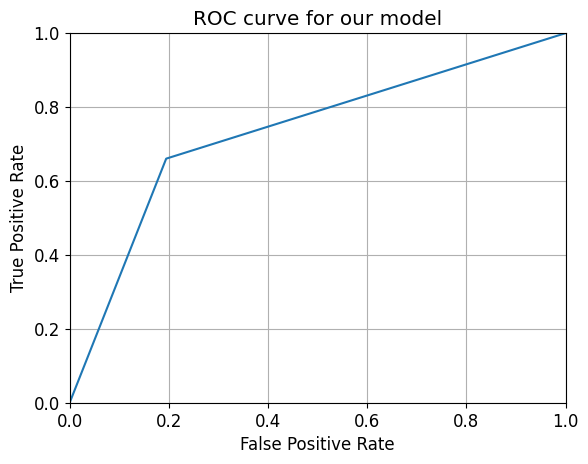

In [38]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)



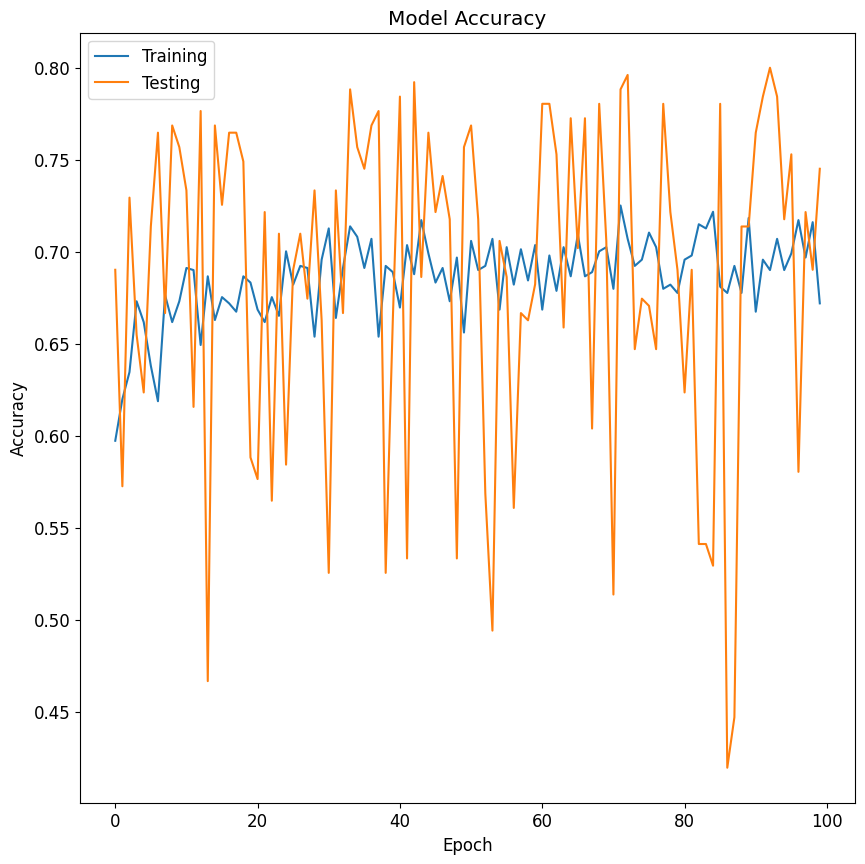

In [39]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_accuracy.png')
plt.show()


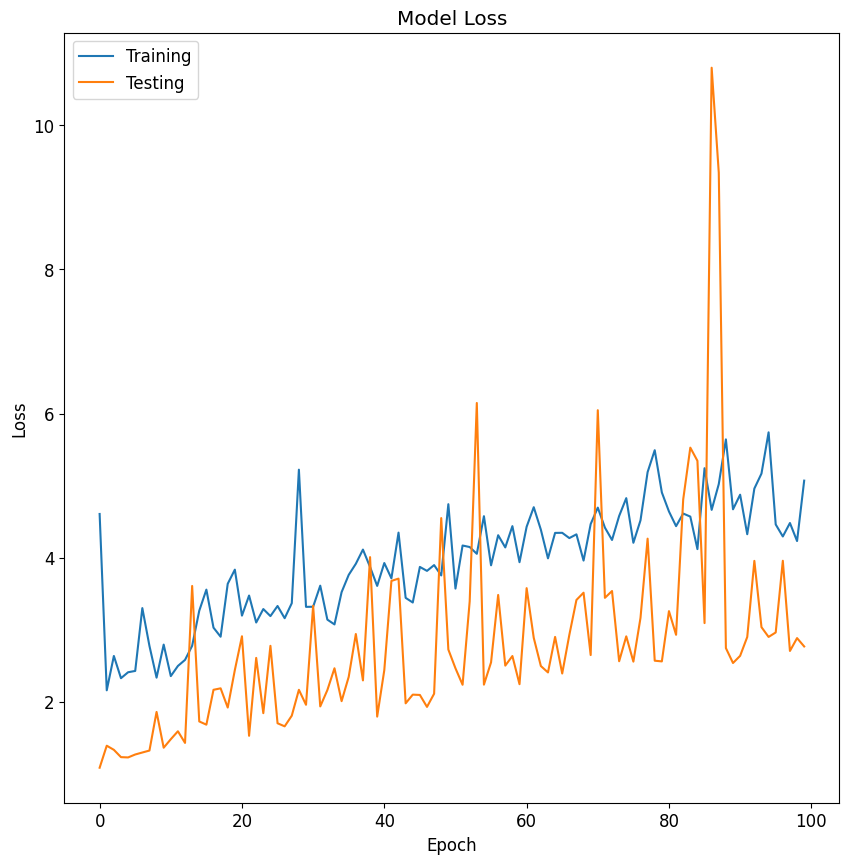

In [40]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_resnet_v2_glaucoma_loss.png')
plt.show()

